# Regression - Gold Price

## 一、前言
- 作者：Alex Kim
- 标题：How to Model Gold Price
- 目的：**利用机器学习中的监督学习模型（supervised learning model）来理解和预测黄金价格走势**
- 原文地址：https://towardsdatascience.com/how-to-model-gold-price-940e809ac665
- 源码地址：https://github.com/ayh9kim/Commodity/blob/master/Gold/Gold%20Price%20Model%20-%20Version%201.0.ipynb

**声明**

1. 本文只是出于学习的目的将其翻译成中文并附上一定的注释，并没有打算将其用作盈利的意图。
2. 好几年没有接触 sklearn 了，我自己也是抱着学习的态度来研究这篇文章。




## 二、影响金价的因素
从理论上讲，有很多基本面、宏观和情感因素会影响黄金价格。在基本面方面，央行、金饰买家和ETF对实物黄金有需求，而在宏观领域，则存在通胀、利率、货币供应和美元走强。此外，一些交易者跟踪CFTC净头寸数据，以衡量投机者的情绪都会影响到金价的走势。


:::{figure-md} markdown-fig
<img src="https://pic.f10.org/i/2022/06/02/fcpklp.png" alt="影响金价的因素" class="bg-primary mb-1">

理论上每个因素如何影响黄金价格？ By Alex Kim
:::


基本面因素的影响是最容易理解的。政府和人民购买的黄金越多，市场上的黄金就越少，价格应该会攀升。

在宏观空间中，通货膨胀（通货紧缩）率是衡量一篮子商品和服务价格上涨（下降）的指标。如果通货膨胀率上升，我们的日常开销和黄金的价格也会上涨。相反，如果利率上升，黄金作为投资工具相对于国债变得没有吸引力。就像巴菲特说的，黄金是一只不下蛋的母鸡。

```{epigraph}
“如果你永远拥有一盎司黄金，你仍然拥有一盎司黄金。
```

最重要的因素之一是货币供应量(M2)，它衡量经济中可用的总货币。让我们举两个例子来解释为什么货币供应量的增加会增加黄金价格。
1. 想象一下，只有你和你朋友的一个小经济体，他们同意用你的垄断资金互相买卖黄金。如果你开始在车库里印制垄断资金，并开始从你的朋友那里购买所有的黄金，那么相对于你的垄断地位，黄金的价格就会攀升。换句话说，如果美联储开始印制大量美元，黄金相对于美元的价格可能会攀升。
2. 再想象一下，只有你和你朋友的小型经济体，他们用美元进行交易。如果你印钞票给每个人免费的钱，商品和服务的价格将会增加，因为免费的钱将用于购买额外的商品和服务。货币供应量的增加最终又回到了通货膨胀率的上升上，因此黄金价格可以上涨。

最后一点，美元的走强可能会影响黄金和任何其他以美元计价的大宗商品的价格。如果美元走弱，其他国家可以购买更多的美元，然后购买更多的黄金，推高黄金价格，以及其他商品，只要它们以美元报价。

## 三、对黄金价格进行建模
为了对黄金价格进行建模，我们首先收集输入数据并对数据进行转换。对于转换后的数据，我们使用线性回归模型(Linear Regression Model)来解释预测因子与黄金价格之间的关系。为了验证模型，将进行样本外回溯测试，并计算R²值以测量模型的性能。

### 1、数据收集
为了准备分析和模型开发，收集并清理了自1981年以来的以下数据：
- XAUUSD：黄金现货价格以美元计价。
- 美国 CPI：该指数跟踪城市消费者支付的商品和服务价格的变化（即通货膨胀率）。
- 美国 M2：货币供应量包括现金，支票存款和易于兑换的货币。
- 美国 GDP：衡量美国经济产出规模的特色指标。
- 美元指数：追踪美元相对于一篮子外币的价值的指数。

:::{figure-md} markdown-fig
<img src="https://pic.f10.org/i/2022/06/02/fjba8s.png" alt="输入数据和来源" class="bg-primary mb-1">

输入数据和来源 By Alex Kim
:::


**值得注意的是，这些数据集的时间周期是不一样的，为了对齐频率，作者将这些值按季度分组，然后取平均值。**


In [1]:
## library
import os
from functools import reduce
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## ML library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

## config setting
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# 读取sample数据
df = pd.read_csv('gold_model_sample_data.csv', index_col='Date')
df.index = pd.to_datetime(df.index)

# 调整统一数据时间周期
df_train = df.resample('3M').mean().dropna()
df_train.head()

,M2,GDP,CPI,XAUUSD,DXY
Date,,,,,
1981-02-28,1605.015385,3124.206,87.200000,549.603333,92.662833
1981-05-31,1651.700000,3162.532,89.133333,490.890625,99.513538
1981-08-31,1682.042857,3260.609,91.400000,425.621538,109.737879
1981-11-30,1721.830769,3280.818,93.433333,431.253968,106.275500
1982-02-28,1763.175000,3274.302,94.400000,389.311475,107.489833


### 2、数据转换和特征工程
Feature Engineering: Inflation Adjusted Gold Price, M2/GDP

#### （1）目标变量
该模型中的目标变量是针对通货膨胀进行调整的黄金现货价格。为了通过通货膨胀调整黄金现货价格，我们按美国CPI调整黄金现货价格。展望未来，这种通胀调整后的黄金时间序列将被称为“黄金现货价格（spot price）”，“黄金价格（gold price）”或“XAUUSD”。

#### （2）预测变量
此回归模型有两个预测变量：货币供应量M2与 GDP  的比率（M2/GDP）和美元指数。虽然美元指数可以保持原样，但我们需要通过将美国M2除以美国GDP来得出该比率。货币供应量M2与GDP的比率优于货币供应量，因为它是衡量经济中货币供应过剩的指标。

In [3]:
# inflation adjustment
df_train['CPI'] = df_train['CPI']/df_train.iloc[0,:]['CPI']
df_train['XAUUSD'] = df_train['XAUUSD']/df_train['CPI']

# M2/GDP
df_train['M2/GDP'] = df_train['M2']/df_train['GDP']
df_train.head()

,M2,GDP,CPI,XAUUSD,DXY,M2/GDP
Date,,,,,,
1981-02-28,1605.015385,3124.206,1.000000,549.603333,92.662833,0.513735
1981-05-31,1651.700000,3162.532,1.022171,480.243035,99.513538,0.522271
1981-08-31,1682.042857,3260.609,1.048165,406.063437,109.737879,0.515868
1981-11-30,1721.830769,3280.818,1.071483,402.483190,106.275500,0.524818
1982-02-28,1763.175000,3274.302,1.082569,359.618227,107.489833,0.538489


In [4]:
# rename
df_train.index.name = 'Date'

# drop columns
df_train.drop(columns=['M2', 'GDP', 'CPI'], inplace=True)

````{margin}
```{admonition} log transformation
:class: seealso

`How to know if a time series is stationary or non-stationary? `
In the particular case of time series analysis of financial data, it might be helpful to review a high-quality statistical text, such as Statistics and Data Analysis for Financial Engineering, Second Edition (David Ruppert & David S. Matteson). On page 308, we find the remark
> As mentioned, many financial time series do not exhibit stationarity, but often the changes in them, perhaps after applying a **log transformation**, are approximately stationary.

[source](https://stats.stackexchange.com/questions/497877/forecasting-prices-vs-returns-by-deep-learning)
```
````

#### （3）log transformation
在两次变换之后，我们将对数变换应用于目标变量和预测变量，因为所有值都是正的并且表现出高正偏度。这将有助于任何线性模型更轻松地找到模式。

In [ ]:
# log transformation
df_train = df_train.apply(np.log)

### 3、观察数据

In [6]:
df_train.columns = ['XAUUSD', 'DXY', 'M2/GDP']

(0.0, 3.0)

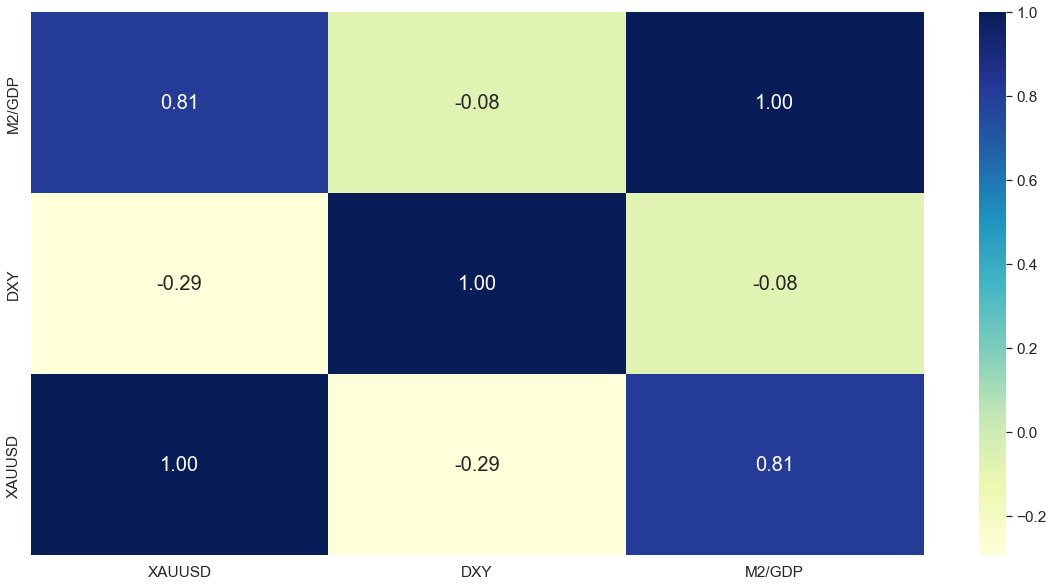

In [7]:
sns.set(font_scale=1.4)
ax = sns.heatmap(data=df_train.corr(), annot=True, fmt='.2f', cmap='YlGnBu', annot_kws={"size": 20})
ax.set_ylim(0, 3)

使用变换后的变量，我们绘制了一个相关矩阵，以了解黄金价格和预测因子之间的线性关系。如图所示，黄金现货价格与货币供应量与GDP之比高度相关，与美元指数有一定但呈负相关。


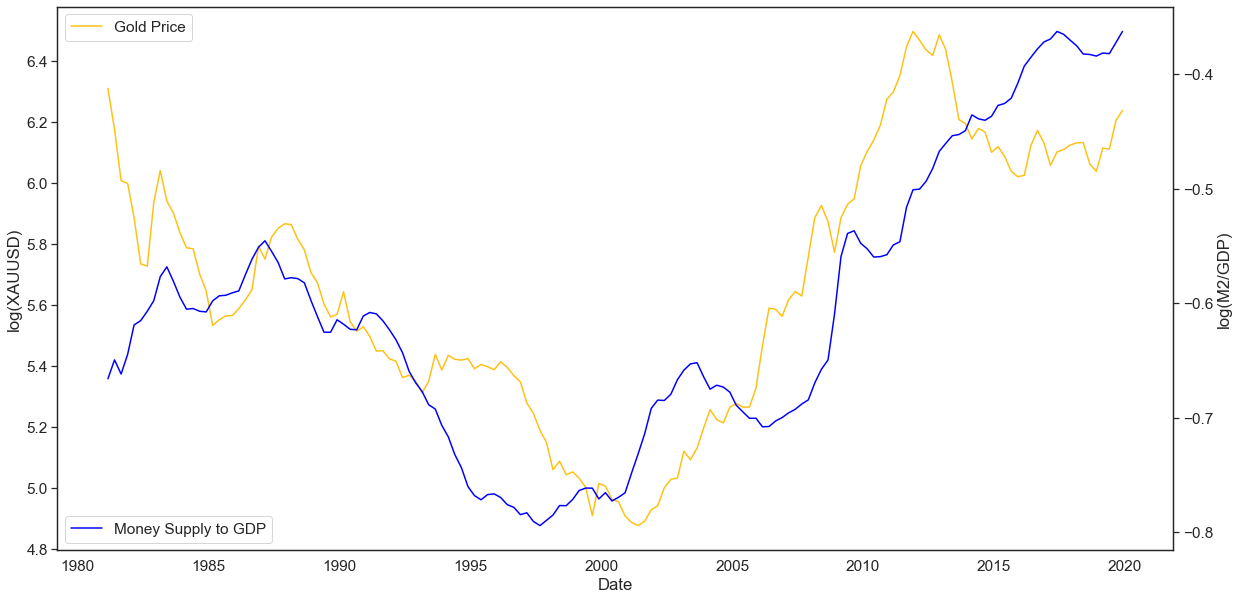

In [8]:
sns.set(font_scale=1.4)
sns.set_style('white')
ax = sns.lineplot(data=df_train.reset_index(), x='Date', y='XAUUSD', color='#ffc114')
ax2 = ax.twinx()
sns.lineplot(data=df_train.reset_index(), x='Date', y='M2/GDP', ax=ax2, color='blue')
ax.set_ylabel('log(XAUUSD)')
ax2.set_ylabel('log(M2/GDP)')
ax.legend(labels=['Gold Price'], loc=2)
ax2.legend(labels=['Money Supply to GDP'], loc=3)

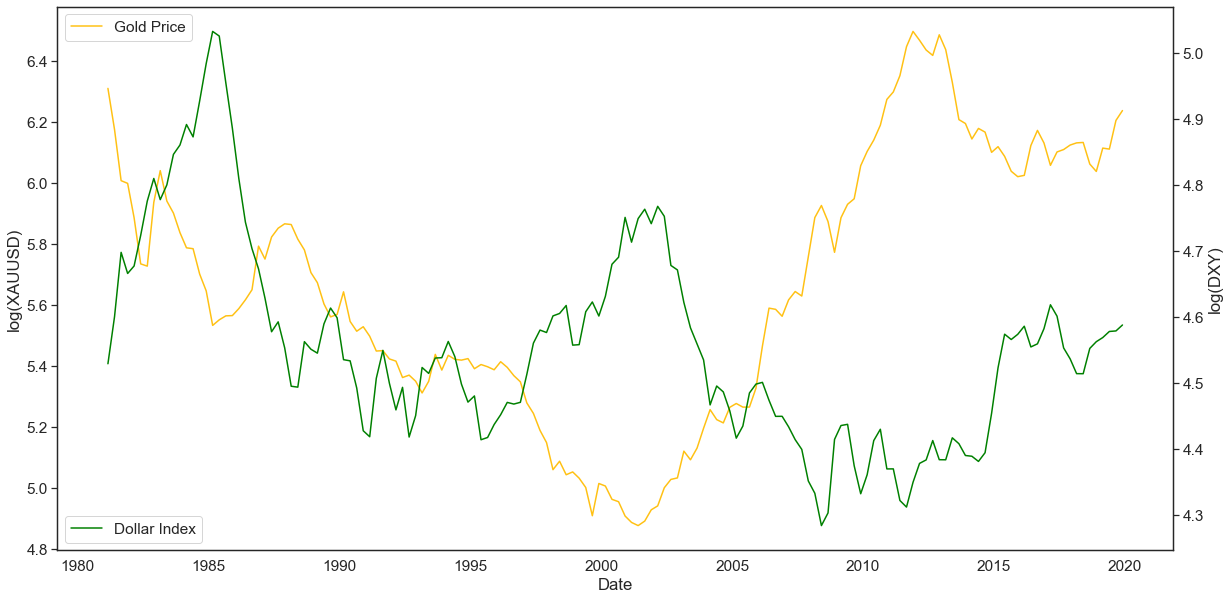

In [9]:
sns.set(font_scale=1.4)
sns.set_style('white')
ax = sns.lineplot(data=df_train.reset_index(), x='Date', y='XAUUSD', color='#ffc114')
ax2 = ax.twinx()
sns.lineplot(data=df_train.reset_index(), x='Date', y='DXY', ax=ax2, color='green')
ax.set_ylabel('log(XAUUSD)')
ax2.set_ylabel('log(DXY)')
ax.legend(labels=['Gold Price'], loc=2)
ax2.legend(labels=['Dollar Index'], loc=3)

更重要的是，这两个预测变量的**相关性值为 -0.08**，这表明，即使美元指数的相关性小于货币供应量与GDP的比率，美元仍然有用，因为它可能会添加非重叠的信息。

### 4、模型训练和回溯测试性能
现在使用预测变量和目标变量，我们使用具有线性回归方程的两个预测因子来拟合黄金价格。

:::{figure-md} markdown-fig
<img src="https://pic.f10.org/i/2022/06/02/gxy5hh.png" alt="黄金价格线性回归模型" class="bg-primary mb-1">

黄金价格线性回归模型 By Alex Kim
:::

请注意，添加 L1 和 L2 正则化参数以减少过度拟合不太可能在此模型中添加值，因为预测变量数量少，预测变量之间的相关性很小。无论如何，包括随机森林和XGBoost在内的其他算法也可以进行训练。

:::{figure-md} markdown-fig
<img src="https://pic.f10.org/i/2022/06/02/gykjzy.png" alt="样本外回溯测试结果表明，不需要复杂的模型。" class="bg-primary mb-1">

样本外回溯测试结果表明，不需要复杂的模型。 By Alex Kim
:::


为了评估此模型，通过使用100个单季度的滑动窗口反复训练模型并预测下一季度的平均金价来进行样本外回溯测试。`最终，将预测值与实际值进行比较以计算R²，R²约为92%。`

```{admonition} R²
:class: seealso

R² 是决定系数，表示模型可以解释的总变异的百分比。因此，这个简单的模型可以解释黄金价格总变化的92%。

```


In [10]:
# X, Y
dfY, dfX = df_train[['XAUUSD']], df_train[['DXY', 'M2/GDP']]

In [11]:
def run_model(model, dfX, dfY, n_split):
    count = 0
    df = pd.DataFrame(columns=['pred', 'actual'])
    for idx in range(len(dfX.values)-n_split, len(dfX.values)-1):

        # train, test index
        train_index, test_index = np.arange(idx-n_split, idx, 1), np.array([idx+1])

        # train, test set
        X_train, X_test = dfX.values[train_index], dfX.values[test_index]
        y_train, y_test = dfY.values[train_index], dfY.values[test_index]

        # model
        model.fit(X_train, y_train)
        df.loc[count, 'pred'] = model.predict(X_test)[0]

        # target
        df.loc[count, 'actual'] = y_test[0][0]

        count += 1
        
    error = np.mean(np.power(df['actual'] - df['pred'], 2))
    return(error, model)
            

In [16]:
# training using a sliding window of size 100 with 55 prediction
n_split = 56
df_pred = pd.DataFrame(columns=['rf', 'lasso', 'ridge', 'xgb', 'average', 'target'])

count = 0
for idx in range(len(dfX.values)-n_split, len(dfX.values)-1):
    
    # train, test index
    train_index, test_index = np.arange(idx - len(dfX.values) + n_split, idx, 1), np.array([idx+1])
    
    # train, test set
    X_train, X_test = dfX.values[train_index], dfX.values[test_index]
    y_train, y_test = dfY.values[train_index], dfY.values[test_index]

    #LinearRegression
    linearregression = LinearRegression()
    linearregression.fit(X_train, y_train)
    df_pred.loc[count, 'linearregression'] = linearregression.predict(X_test)[0][0]   
    
    # lasso
    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train, y_train)
    df_pred.loc[count, 'lasso'] = lasso.predict(X_test)[0]
    
    # ridge
    ridge = Ridge(alpha=0.001) # set to really low alpha for unregularized linear regression
    ridge.fit(X_train, y_train)
    df_pred.loc[count, 'ridge'] = ridge.predict(X_test)[0][0]

    # random forest
    
    rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_split=3, min_samples_leaf=1, max_samples=0.9)
    rf.fit(X_train, y_train.flatten())
    df_pred.loc[count, 'rf'] = rf.predict(X_test)[0]
    
    # xgboost
    xgb = XGBRegressor(learning_rate=0.2, n_estimators=100, max_depth=1, min_samples_split=1, min_samples_leaf=1,
                       subsample=0.7, nthread=-2)
    xgb.fit(X_train, y_train)
    df_pred.loc[count, 'xgb'] = xgb.predict(X_test)[0]
    
    # average
    df_pred.loc[count, 'average'] = np.mean(y_train)
    
    # target
    df_pred.loc[count, 'target'] = y_test[0][0]
    
    count += 1

[16:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:57:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parame

KeyboardInterrupt: 

In [15]:
# r-squared and mean loss
lst_pred = ['linearregression', 'lasso', 'ridge', 'rf', 'xgb']
total_error = np.mean(np.power(df_pred['target'] - df_pred['average'], 2))
print('total error is: %.2f' % total_error)
for pred in lst_pred:
    tmp_mean_loss = np.mean(np.power(df_pred['target'] - df_pred[pred], 2))
    tmp_r_squared = 1 - tmp_mean_loss / total_error
    print(pred + ' has a mean loss of : %.2f' % tmp_mean_loss)
    print(pred + ' has a r-squared of : %.2f' % tmp_r_squared)

total error is: 0.40
linearregression has a mean loss of : 0.03
linearregression has a r-squared of : 0.92
lasso has a mean loss of : 0.04
lasso has a r-squared of : 0.90
ridge has a mean loss of : 0.03
ridge has a r-squared of : 0.92
rf has a mean loss of : 0.04
rf has a r-squared of : 0.90
xgb has a mean loss of : 0.04
xgb has a r-squared of : 0.90


### 5、如何使用此模型
使用这个模型，我们可以通过将我们对货币供应量的看法转化为GDP，**美元走强和通货膨胀率来预测黄金价格**。

在作者看来，货币供应量与GDP的比率将在短期和长期内增加，因为政府将继续印钞票，以抵消全球封锁的影响和信贷市场的担忧。

然而，美元指数可能会看到避险需求带来的一些走强。当市场发生抛售时，对美元等避险资产的需求增加，从而支撑美元。

综上所述，我预计黄金价格在短期内仍将保持相当波动，因为这两个预测因素可以相互抵消。然而，从长远来看，作者相信期待已久的牛市会卷土重来。
